In [1]:
threads=16
import os
os.environ['OMP_NUM_THREADS']=str(threads)
import torch

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
import urllib
import pickle
import rassp
from rassp import netutil
from rdkit import Chem
import numpy as np

In [3]:
# XXX: needed by pickle.load of rassp models

from rassp import msutil,model
import sys
sys.modules['msutil'] = msutil
sys.modules['model'] = model

In [ ]:
s = pd.read_parquet('rassp-public/sample_data/smallmols_cfm_pred_public_sample.parquet')

In [ ]:
s.iloc[0].spect

In [ ]:
s.iloc[0].spect_sparse

In [ ]:
s.iloc[0]

In [ ]:
m = Chem.Mol(s.iloc[1].rdmol)
m

In [ ]:
[ a.GetAtomicNum() for a in m.GetAtoms()]

### TODO 

Z toho pouziva RASSP jen spect a rdmol
rdmol je serializovany rdkit.Chem.Mol

to budeme umet z MSP vyrobit

In [ ]:
base='https://people.cs.uchicago.edu/~ericj/rassp/'
files=[ 'formulanet_best_candidate_pcsim_pretrain.nist-fromscratch-3x9x128.35790555.00000740.model',    
'formulanet_best_candidate_pcsim_pretrain.nist-fromscratch-3x9x128.35790555.meta',
'subsetnet_best_candidate_nist_fromscratch.nist-fromscratch-test01-old-1x2048.36688199.00001000.model', 
'subsetnet_best_candidate_nist_fromscratch.nist-fromscratch-test01-old-1x2048.36688199.meta',   
'subsetnet_best_candidate_nist_posttrain_cluster.cluster-nist-posttrain.35946017.00000480.model',
'subsetnet_best_candidate_nist_posttrain_cluster.cluster-nist-posttrain.35946017.meta']

for f in files:
    urllib.request.urlretrieve(f'{base}/{f}',f)

In [8]:
# from original run_rassp.py

use_gpu=True
model_dir='.'

MODELS = {
    'FormulaNet': {
        'checkpoint': os.path.join(model_dir, 'formulanet_best_candidate_pcsim_pretrain.nist-fromscratch-3x9x128.35790555.00000740.model'),
        'meta': os.path.join(model_dir, 'formulanet_best_candidate_pcsim_pretrain.nist-fromscratch-3x9x128.35790555.meta'),

        # NOTE(2023-01-24): FN currently has a reduced set of valid mol constraints bc this is what we trained with
        # and there is currently an outstanding bug where changing N_ATOMS here breaks FN predictions in subtle ways.
        'override_constraints': {
            'n_atom': 48,
            # 'n_formula': 4096,
            'n_formula': 32768,
            # 'n_subset': 12288,
            'n_subset': 49152,
        },
    },
    'SubsetNet': {
        'checkpoint': os.path.join(model_dir, 'subsetnet_best_candidate_nist_fromscratch.nist-fromscratch-test01-old-1x2048.36688199.00001000.model'),
        'meta': os.path.join(model_dir, 'subsetnet_best_candidate_nist_fromscratch.nist-fromscratch-test01-old-1x2048.36688199.meta'),

        # NOTE: this set of params works for SN GPU inference on a single RTX 2080 Ti (12GB VRAM)
        # despite SN being trained on <= 48 atoms like FN, it also scales well to mols up to <= 64 atoms (tested)
        'override_constraints': {
            'n_atom': 64,
            'n_formula': 32768,
            'n_subset': 49152,
        },
    },
}

model_name='FormulaNet'
meta_path = MODELS[model_name]['meta']
ckpt_path = MODELS[model_name]['checkpoint']
override_constraints = MODELS[model_name]['override_constraints']
meta = pickle.load(open(meta_path, 'rb'))

feat_config = meta['featurize_config']
for key, val in override_constraints.items():
    if key == 'n_atom':
        feat_config['MAX_N'] = val
    if key == 'n_formula':
        feat_config['explicit_formulae_config']['max_formulae'] = val
    if key == 'n_subset':
        feat_config['vert_subset_samples_n'] = val

if use_gpu and not torch.cuda.is_available():
    use_gpu = False

predictor = netutil.PredModel(
    meta_path,
    ckpt_path,
    USE_CUDA=use_gpu,
    data_parallel=False,
    featurize_config_update=feat_config,
)


In [68]:
smiles = ['C1=CNN=C1','CC(C)C#N','CCC(=C)C','CC[N+](=O)[O-]','C1=CSC(=N1)N=C(C(C(F)(F)F)(OC(C(C(F)(F)F)(OC(C(C(F)(F)F)(F)F)(F)F)F)(F)F)F)N'] 

valid_mols = [ Chem.AddHs(Chem.MolFromSmiles(s)) for s in smiles ]

In [69]:
predictions = predictor.pred(
    valid_mols,
    progress_bar=True,
    normalize_pred=True,
    output_hist_bins=True,
    batch_size=2, # XXX
    dataloader_config={
        'pin_memory': False,
        'num_workers': 0, # XXX
        'persistent_workers': False,
    },
    benchmark_dataloader=False,
)


100%|██████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  6.53it/s]


In [70]:
shit_pred17 = predictions['pred_binned']

In [ ]:
nist_path = '20210925_NIST_EI_MS_cleaned.msp'

from matchms.importing import load_from_msp
nist = list(load_from_msp(nist_path, metadata_harmonization=False))

In [ ]:
len(nist)

In [ ]:
nist[42].metadata

In [ ]:
nist[42].peaks.mz

In [ ]:
nist[42].peaks.intensities

In [ ]:
mol = Chem.AddHs(Chem.MolFromSmiles(nist[42].metadata['smiles']))
len(mol.GetPropNames())

In [ ]:
b = mol.ToBinary()
b

In [ ]:
m2 = Chem.Mol(b)
m2

In [ ]:
import numpy as np
a=np.stack([nist[42].peaks.mz,nist[42].peaks.intensities],axis=1)
a

In [ ]:
bb = np.empty(shape=(a.shape[0],),dtype=object)
bb[:] = list(a)
bb

In [ ]:
np.array(list(a),dtype=object)

In [ ]:
n=nist[42]
np.array([ np.array(p,dtype=object) for p in zip(n.peaks.mz, n.peaks.intensities)])
#[ np.array(p) for p in zip(n.peaks.mz, n.peaks.intensities)]

In [22]:
valid_atoms = {1, 6, 7, 8, 9, 15, 16, 17}
# FIXME: rassp/msutil/shared.h
# not acceptable, narrows down the model too much, we need Br, Si at least

# requires isotopic data in rassp/msutil/floatmasseval_per_elt_peaks.h

# dtto MAX_N == 48

def mkdf(nist2):
    mols = [ ]
    spects = []
    smiles = []
    for i,n in enumerate(nist2):
        if n.metadata.get('smiles') is None:
            print(i,'no smiles')
            continue
        mol = Chem.MolFromSmiles(n.metadata['smiles'])
        if mol is None: 
            print(i,n.metadata['smiles'][:100],'... cant parse')
            continue 
        mol = Chem.AddHs(mol)
        if mol is None: 
            print(i,n.metadata['smiles'],'... cant add Hs')
            continue 
            
        if len(mol.GetAtoms()) > 48:
            print(i,n.metadata['smiles'],'... too many atoms')
            continue
        
        atoms = { a.GetAtomicNum() for a in mol.GetAtoms() }
        if not atoms < valid_atoms:
            print(i,n.metadata['smiles'],atoms,'... invalid atom')
            continue
        
        mols.append(mol.ToBinary())
        a = np.stack([n.peaks.mz, n.peaks.intensities], axis=1)
        b = np.empty(shape=(a.shape[0],),dtype=object)
        b[:] = list(a)
        spects.append(b)
        smiles.append(n.metadata['smiles'])

    df = pd.DataFrame.from_dict({ 'rdmol' : mols, 'spect' : spects, 'smiles' : smiles })
    return df

In [ ]:
len(m.GetAtoms())

In [23]:
%%capture
trd = mkdf(nist)

NameError: name 'nist' is not defined

In [ ]:
trd

In [ ]:
test_mask = np.random.choice([True, False], p=[.2,.8], size=len(trd))

In [ ]:
trd[test_mask == False].to_parquet('train.pq')

In [ ]:
td = pd.read_parquet('train.pq')                    

In [ ]:
td.iloc[0].spect

In [ ]:
%%capture
tstd = mkdf(nist[1:1000:2])

In [ ]:
#tstd.to_parquet('test.pq')
trd[test_mask].to_parquet('test.pq')

In [ ]:
tstd

In [4]:
sys.path.append('./rassp-public/rassp')
from forward_train import train

In [5]:
import yaml
with open('rassp-public/rassp/expconfig/demo.yaml') as cf:
    exp_config = yaml.load(cf,Loader=yaml.FullLoader)

In [6]:
exp_config['cluster_config']['data_dir'] = '.'
exp_config['DATALOADER_NUM_WORKERS'] = 8
exp_config['max_epochs'] = 200
exp_config['epoch_size'] = 4096
exp_config['batch_size'] = 4
exp_config['automatic_mixed_precision'] = False # broken
exp_config['featurize_config']['explicit_formulae_config']['max_formulae'] = 27000 # XXX
exp_config['exp_data']['data'][0]['db_filename'] = 'train.pq'
exp_config['exp_data']['data'][1]['db_filename'] = 'test.pq'

with open('exp.yml','w') as y:
    yaml.dump(exp_config,y)

In [7]:
train('test',exp_config,exp_config_filename='exp.yml',USE_CUDA=True)

using checkpoint_dir: checkpoints
we are training with 154779
we are testing with 38662
it took 3.0s to load the data
{'init_noise': 0.01, 'init_bias': 0.0, 'resnet': True, 'int_d': 512, 'layer_n': 16, 'agg_func': 'goodmax', 'gml_class': 'GraphMatLayersNormAfterRes', 'gml_config': {'layer_class': 'GraphMatLayerFast3', 'layer_config': {'dropout': 0.0, 'nonlin': 'leakyrelu', 'swap_init': False}}, 'g_feature_n': 45, 'inner_norm': 'layer', 'input_norm': 'batch', 'spect_out_class': 'MolAttentionGRU', 'spect_out_config': {'formula_oh_sizes': [50, 46, 30, 30, 30, 30, 30, 30], 'formula_oh_accum': True, 'internal_d': 128, 'embedding_key_size': 8, 'gru_layer_n': 3, 'linear_layer_n': 9}, 'GS': 4, 'spect_bin': <rassp.msutil.binutils.SpectrumBins object at 0x7f5b873d6f70>}
GCN module had 15869952 nparams
Spectral module had 3862321 nparams
Net overall had 19732363 nparams
NOT LOADING FROM ANY CHECKPOINT
NOT USING CUSTOM COLLATE_FN
gml.gl.0.weight                                     (4, 512, 45) 
gm

/opt/conda/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
2023-03-06 19:17:17.720723: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 19:17:17.790955: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-06 19:17:17.792955: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic li

MODEL_NAME= test.78130231


  0%|                                                                                    | 0/200 [00:48<?, ?it/s]


RuntimeError: Caught RuntimeError in DataLoader worker process 7.
Original Traceback (most recent call last):
  File "/build/rassp/dataset/__init__.py", line 96, in __getitem__
    features_dict = self.featurizer(mol)
  File "/build/rassp/featurize/featurize.py", line 126, in __call__
    formulae_feats, formulae_peaks = self.pff(mol)
  File "/build/rassp/featurize/molecule_features.py", line 658, in __call__
    raise ValueError(f"molecule {Chem.MolToSmiles(mol)} has {len(formulae)}, more than the limit of {self.max_formulae} (naive count={self.num_unique_f(mol)})")
ValueError: molecule [H]c1nc(N=C(N([H])[H])C(F)(OC(F)(F)C(F)(OC(F)(F)C(F)(F)C(F)(F)F)C(F)(F)F)C(F)(F)F)sc1[H] has 28080, more than the limit of 27000 (naive count=28080)

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/build/rassp/dataset/__init__.py", line 99, in __getitem__
    raise RuntimeError(row.smiles) from e
RuntimeError: C1=CSC(=N1)N=C(C(C(F)(F)F)(OC(C(C(F)(F)F)(OC(C(C(F)(F)F)(F)F)(F)F)F)(F)F)F)N


In [ ]:
trd[trd.smiles.str.contains('C(Cl)Br',regex=False)]
#trd[trd.smiles.str.contains('Br',regex=False)]

In [ ]:
m=Chem.Mol(trd.iloc[7208].rdmol)
m

In [ ]:
not {a.GetAtomicNum() for a in m.GetAtoms()} < {1,2,6,7,8,9,15,16,17}

In [24]:
trd = pd.read_parquet('train.pq')

In [74]:
shit_nist=trd[trd.smiles.str.contains({*smiles},regex=False)]

KeyError: "None of [Float64Index([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,\n              ...\n              nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],\n             dtype='float64', length=154779)] are in the [columns]"

In [118]:
idx=4

In [119]:
shit_nist=trd[trd.smiles == smiles[idx]]
shit_nist

,rdmol,spect,smiles
193300,b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\x...,"[[33.0, 10.99], [34.0, 20.98], [35.0, 6.99], [...",C1=CSC(=N1)N=C(C(C(F)(F)F)(OC(C(C(F)(F)F)(OC(C...


In [120]:
idx2=0

In [121]:
import matchms
mzi=np.array(list(shit_nist.iloc[idx2].spect))
shit1 = matchms.Spectrum(mz=mzi[:,0],intensities=mzi[:,1])
mzi=shit_pred17[idx].astype(float)
shit2 = matchms.Spectrum(mz=mzi[:,0],intensities=mzi[:,1])

2023-03-07 15:49:00,431:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2023-03-07 15:49:00,431 - matchms - WARNING - No precursor_mz found in metadata.


2023-03-07 15:49:00,433:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


2023-03-07 15:49:00,433 - matchms - WARNING - No precursor_mz found in metadata.


<Axes: title={'center': 'Spectrum comparison'}, xlabel='m/z', ylabel='Intensity'>

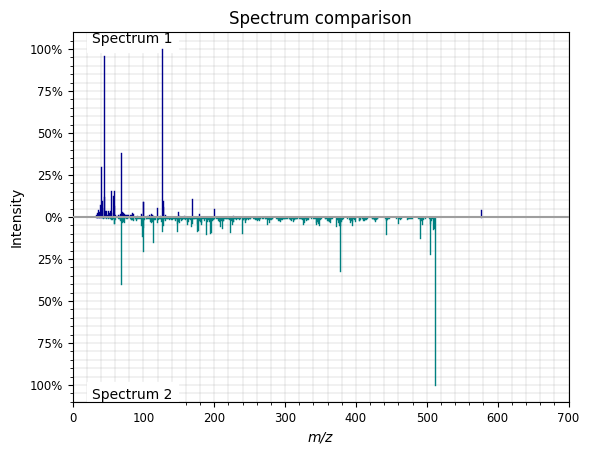

In [122]:
from matchms.plotting import plot_spectra_mirror
plot_spectra_mirror(shit1,shit2)